# LoC image analysis - auto 1 using 2nd deriv

This notebook is designed to assess the feasability of segmenting the basal and apical sides of the coculture, with different cell sizes, using the same segmentation run through.

In [12]:
import os
import glob
import enum
from octopusheavy import DaskOctopusHeavyLoader
import napari
from skimage.io import imshow,  imsave, imread
import napari
import btrack
from tqdm.auto import tqdm
import dask.array as da
import numpy as np

# Loading images

Define root path and individual experiment IDs

In [2]:
root_path = '/run/user/30046150/gvfs/smb-share:server=data.thecrick.org,share=lab-gutierrezm/home/shared/Lung on chip/Light microscopy'

In [3]:
expt_IDs = ['co-culture/iVECs+iAT2AT1/Folder_20220808/A2-A5/analysis_20221125/DAPI-SPC-PDPN-ZO1/_20220808_kolf-WT_co-culture_20x_A2-A5_Multichannel Z-Stack_20220808_60_/images/',
            'co-culture/iVECs+iAT2AT1/Folder_20220808/A2-A5/analysis_20221125/DAPI-VWF-iCAM1-ZO1/_20220808_kolf-WT_co-culture_20x_A2-A5_Multichannel Z-Stack_20220808_70_/images/',
            'mono-culture/iAT2AT1/for analysis_20221125/DAPI-AQP5-proSPC-ZO1/Day7_static/_20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_150_/images/',
            'mono-culture/iAT2AT1/for analysis_20221125/DAPI-AQP5-proSPC-ZO1/Day14_static/_20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_262_/images/',
            'mono-culture/iAT2AT1/for analysis_20221125/DAPI-CAV1-proSPC-ZO1/Day7_static/_20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_130_/images/',
            'mono-culture/iAT2AT1/for analysis_20221125/DAPI-CAV1-proSPC-ZO1/Day14_static/_20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_253_/images/'
           ]

In [4]:
expt_ID = expt_IDs[0]

In [5]:
images = DaskOctopusHeavyLoader(os.path.join(root_path, expt_ID))

In [6]:
images.channels

[<Channels.CH1: 1>,
 <Channels.CH2: 2>,
 <Channels.CH3: 3>,
 <Channels.CH4: 4>,
 <Channels.MASK1: 99>]

In [7]:
import enum
@enum.unique
class Channels(enum.Enum): ### this is unique to the above acquisition (20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_113.vsi - 005 CF405, CF488, CF561, CF638.tif)
    DAPI = 1
    SPC = 2
    PDPN = 3
    ZO1 = 4
    MASKS = 99

# Segmentation testing

In [8]:
!nvcc --version
!nvidia-smi

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(16,12), dpi=80)

from cellpose import core, utils, io, models, metrics

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Wed Dec  7 16:05:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:65:00.0  On |                  Off |
| 30%   36C    P8    33W / 300W |  19981MiB / 49140MiB |     21%      Default |
|                               |                      |                  N/A |
+

<Figure size 1280x960 with 0 Axes>

### Partially automated using second derivative of cell count

In [13]:
%%time
# define model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=use_GPU, model_type='cyto')
# define CHANNELS to run segementation on
channels = [0,0]
### define empty mask stack 
mask_stack, n_labels = [], []
### iterate over frames
for i, (image, fn) in tqdm(enumerate(zip(images['CH4'], images.files('CH4'))), total = len(images['CH4'])):
    ### firstly iterate over image set and segment on automatic which captures apical side well
    apical_masks, flows, styles, apico_diams = model.eval(image, 
                                                        diameter=None, 
                                                        flow_threshold=None, 
                                                        channels=channels, 
                                                        
                                                       )
    mask_stack.append(apical_masks)
    ### read the number of masks by measuring the max label value (quicker than regionprops)
    n_labels.append(np.max(apical_masks))
### plot the second derivative of the number of masks and find the maximum
### this corresponds to the point at which the masks count stops decreasing the most rapidly
### ie the most sudden change in cell count decrease, where the apicobasal trans is?
apicobasal_transition = [n for n, i in enumerate(np.gradient(np.gradient(n_labels))) if i == max(np.gradient(np.gradient(n_labels)))][0]
### now iterate over masks again but rewrite the mask stack with basal labels with larger radius
for i, (image, fn) in tqdm(enumerate(zip(images['CH4'], images.files('CH4'))), total = len(images['CH4'])):
    ### skip all frames before apicobasal transition
    if i < apicobasal_transition:
        continue
    ### estimate sizes of basal masks using measure of apical diameter size
    baso_diams = 10* apico_diams
    ### firstly iterate over image set and segment on automatic which captures apical side well
    basal_masks, flows, styles, diams = model.eval(image, 
                                                diameter=baso_diams, 
                                                flow_threshold=None, 
                                                channels=channels, 
                                               )
    mask_stack.append(basal_masks)

  0%|          | 0/81 [00:00<?, ?it/s]

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/81 [00:00<?, ?it/s]

CPU times: user 29min 35s, sys: 25min 8s, total: 54min 44s
Wall time: 24min 9s


# STRAIGHT UP DOESNT WORK

the gradient method is unreliable

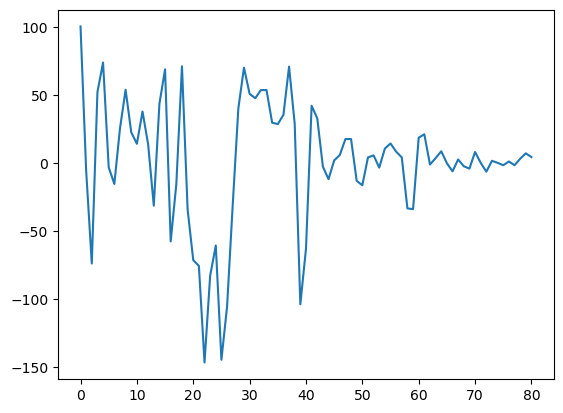

In [29]:
plt.plot(np.gradient(np.gradient(n_labels)))

In [21]:
[n for n, i in enumerate(np.gradient(np.gradient(n_labels))) if i == max(np.gradient(np.gradient(n_labels)))][0]

0

In [20]:
apicobasal_transition

0

In [19]:
len(mask_stack[:81]), len( mask_stack[81:])

(81, 81)

In [14]:
masks = da.stack((mask_stack[:81], mask_stack[81:]), axis = 0)

In [16]:
len(masks)

162

/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(
/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(


In [15]:
v = napari.Viewer()

v.add_image(images['CH4'])
v.add_labels(masks)

Assistant skips harvesting pyclesperanto as it's not installed.


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)
/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(
/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(


<Labels layer 'masks' at 0x7fad5c998310>

/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(
/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(
/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(
/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(
/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image

/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(
/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(
/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(
/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(
/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image

## Testing other params of cellpose

In [39]:
help(model.eval)

Help on method eval in module cellpose.models:

eval(x, batch_size=8, channels=None, channel_axis=None, z_axis=None, invert=False, normalize=True, diameter=30.0, do_3D=False, anisotropy=None, net_avg=False, augment=False, tile=True, tile_overlap=0.1, resample=True, interp=True, flow_threshold=0.4, cellprob_threshold=0.0, min_size=15, stitch_threshold=0.0, rescale=None, progress=None, model_loaded=False) method of cellpose.models.Cellpose instance
    run cellpose and get masks
    
    Parameters
    ----------
    x: list or array of images
        can be list of 2D/3D images, or array of 2D/3D images, or 4D image array
    
    batch_size: int (optional, default 8)
        number of 224x224 patches to run simultaneously on the GPU
        (can make smaller or bigger depending on GPU memory usage)
    
    channels: list (optional, default None)
        list of channels, either of length 2 or of length number of images by 2.
        First element of list is the channel to segment (0=g

In [40]:
images['CH4']

dask.array<stack, shape=(81, 2304, 2304), dtype=float32, chunksize=(1, 2304, 2304), chunktype=numpy.ndarray>

In [42]:
masks, flows, styles, diams = model.eval(images['CH4'], 
                                         diameter=100, 
                                         flow_threshold=None, 
                                         channels=channels, 
                                         progress = True, 
                                         do_3D=True)


SystemError: CPUDispatcher(<function steps3D at 0x7fadee3274c0>) returned a result with an error set

In [ ]:
masks